In [210]:
# Import required libraries
from fastai.vision.all import *
import matplotlib.pyplot as plt
from fastai.vision.widgets import *

#  A.1 Download the data (Assuming already downloaded & extracted into 'data/')
path = Path('dataset/garbage_classification')  # Change this to your actual folder

# A.1.1 Inspect the folder layout
path.ls()


(#12) [Path('dataset/garbage_classification/biological'),Path('dataset/garbage_classification/trash'),Path('dataset/garbage_classification/metal'),Path('dataset/garbage_classification/green-glass'),Path('dataset/garbage_classification/cardboard'),Path('dataset/garbage_classification/clothes'),Path('dataset/garbage_classification/paper'),Path('dataset/garbage_classification/battery'),Path('dataset/garbage_classification/brown-glass'),Path('dataset/garbage_classification/white-glass'),Path('dataset/garbage_classification/plastic'),Path('dataset/garbage_classification/shoes')]

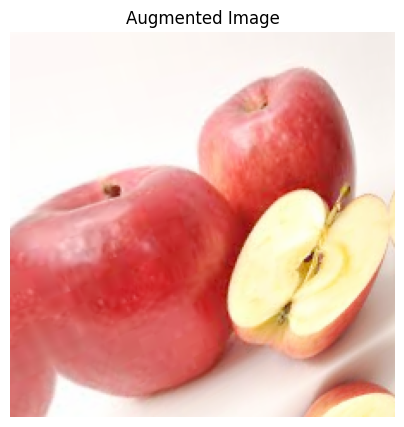

In [211]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

path = Path('dataset/garbage_classification')


img_path = get_image_files(path)[0]
img = PILImage.create(img_path)


aug_tfms = aug_transforms(size=224,
    flip_vert=True,        
    max_rotate=45.0,       
    max_zoom=1.2,         
    max_lighting=0.5,     
    max_warp=0.3,          
    p_affine=0.75,        
    p_lighting=0.75)     


pipeline = Pipeline(aug_tfms, split_idx=0)


img_tensor = TensorImage(array(img).transpose(2,0,1)).unsqueeze(0).float()/255


augmented_img_tensor = pipeline(img_tensor)[0]


show_image(augmented_img_tensor, title="Augmented Image")
plt.show()


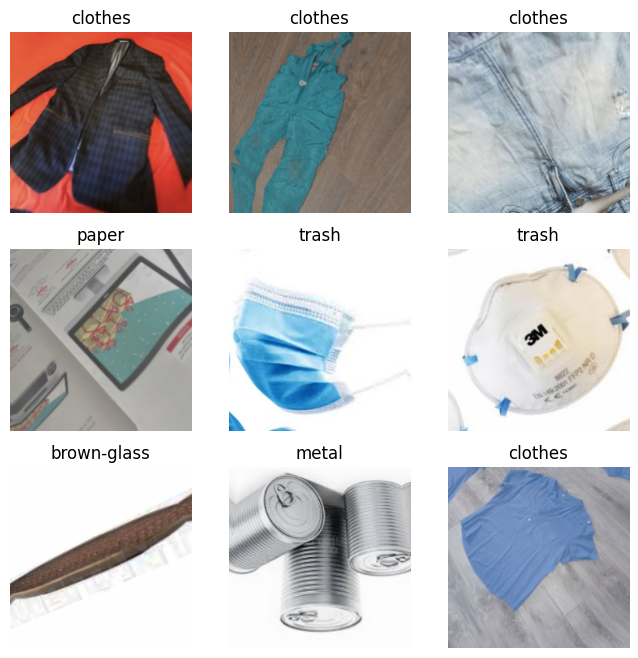

In [212]:
# A.2. Create the DataBlock and dataloaders
garbage_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # A.2.1 Define blocks
    get_items=get_image_files,                      # A.2.2 How to get images
    get_y=parent_label,                             # A.2.3 Get label from folder name
    splitter=RandomSplitter(valid_pct=0.25, seed=42),# Split train/valid
    item_tfms=Resize(240),                          # A Word on Presizing (larger resize first)
    batch_tfms=aug_transforms(size=224,
    flip_vert=True,        
    max_rotate=45.0,       
    max_zoom=1.2,         
    max_lighting=0.5,     
    max_warp=0.3,          
    p_affine=0.75,        
    p_lighting=0.75)             # A.2.4 Batch transforms
)


dls = garbage_block.dataloaders(path, bs=64)

#  A.3.1 Show batch
dls.show_batch(max_n=9, figsize=(8, 8))

In [213]:
# A.3.2 Check labels
print(dls.vocab)
print(f"Number of classes: {len(dls.vocab)}")


['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Number of classes: 12


In [214]:
# A.4.1 Train a simple model (benchmark)
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2)


epoch,train_loss,valid_loss,accuracy,time
0,0.767392,0.281474,0.911810,00:38


epoch,train_loss,valid_loss,accuracy,time
0,0.449080,0.201739,0.938628,00:50
1,0.282389,0.142865,0.955647,00:52


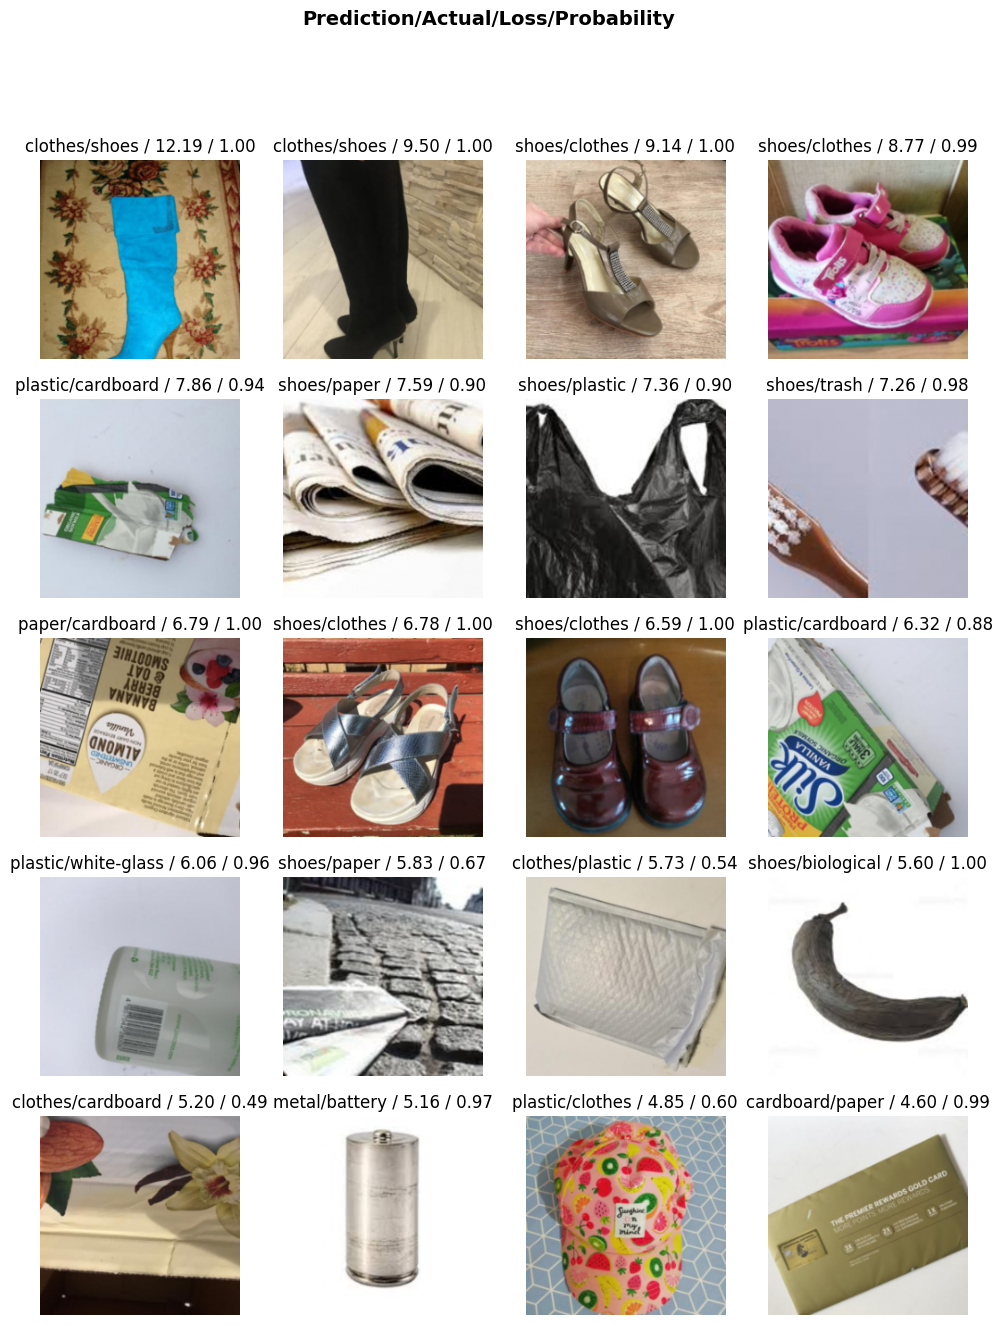

In [215]:
# A.4.2 Interpret model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(20, nrows=5)


In [216]:
cleaner = ImageClassifierCleaner(learn)
cleaner

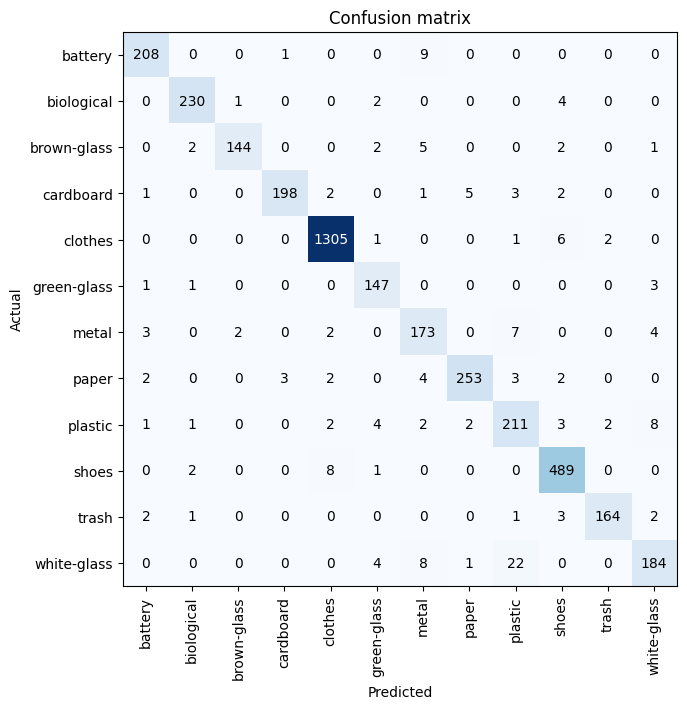

In [217]:
# A.4.3 Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)



SuggestedLRs(minimum=1.58489319801447e-07, steep=8.31763736641733e-06, valley=7.585775847473997e-07, slide=9.120108734350652e-05)

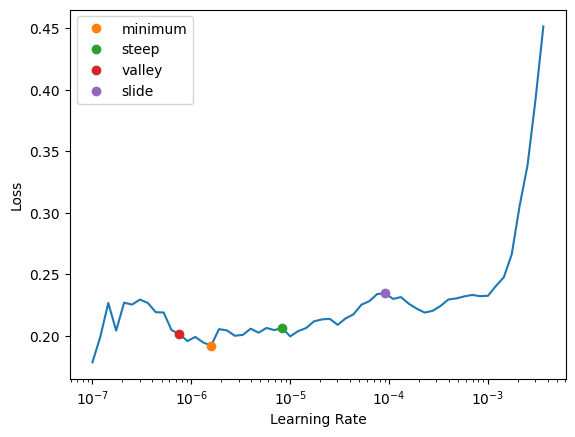

In [220]:
# B.1 Learning Rate Finder
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [221]:
# Choose best learning rate
# Let's pick value just before loss shoots up
learn.fine_tune(6, base_lr=7.585775847473997e-07)
learn.export('models/resnet34_base.pkl')



epoch,train_loss,valid_loss,accuracy,time
0,0.247534,0.145807,0.955647,00:40


epoch,train_loss,valid_loss,accuracy,time
0,0.240134,0.143398,0.954616,00:51
1,0.258062,0.141736,0.955132,00:51
2,0.238458,0.144361,0.954616,00:51
3,0.250124,0.144163,0.954358,01:00
4,0.223664,0.143369,0.954874,01:01
5,0.236291,0.141521,0.956163,00:53


In [222]:
# B.3 Transfer Learning
# used resnet34; the last layer is replaced by fastai
learn.model[1]


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=12, bias=False)
)

SuggestedLRs(minimum=4.786300996784121e-05, steep=6.309573450380412e-07, valley=7.585775892948732e-05, slide=6.30957365501672e-05)

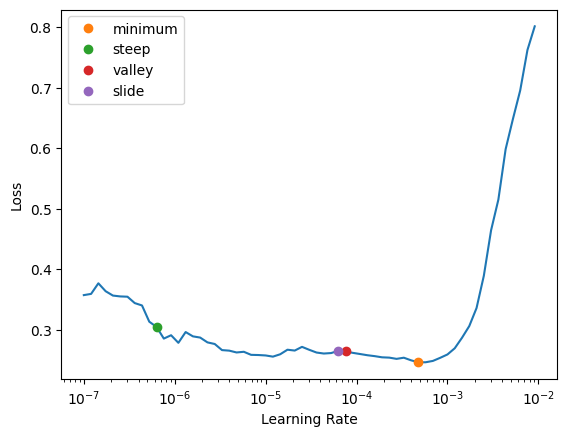

In [223]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [224]:
# Freeze + Train → Unfreeze + Train (B.3) step
learn.freeze()
learn.fit_one_cycle(3, 6.309573450380412e-07)
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(4.786300996784121e-05, 6.309573450380412e-07))   # B.4 Discriminative LRs
learn.export('models/resnet34_freeze_unfreeze_lr.pkl')


epoch,train_loss,valid_loss,accuracy,time
0,0.246344,0.142752,0.955132,00:40
1,0.244742,0.146617,0.954358,00:40
2,0.246892,0.141174,0.956421,00:41


epoch,train_loss,valid_loss,accuracy,time
0,0.234260,0.147379,0.955647,00:52
1,0.217009,0.130835,0.958226,00:52
2,0.214723,0.131419,0.960805,00:53


In [225]:
# B.6 Mixed Precision & Model Capacity
# Use resnet50 and to_fp16
learn = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fine_tune(5) # increase epoch
learn.export('models/resnet50.pkl')

/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.616705,0.236348,0.924961,00:39


epoch,train_loss,valid_loss,accuracy,time
0,0.324729,0.148634,0.952811,00:47
1,0.269748,0.126431,0.964415,00:49
2,0.175998,0.098938,0.970088,00:49
3,0.114463,0.090192,0.973698,00:53
4,0.093620,0.086437,0.974729,00:50
